In [1]:
# A Script for calculating the dropout parameters through the factorized likelihood approach. 
# Plotting of resampled amplitude distribution, dropout parameters included

%matplotlib inlinez
%config InlineBackend.figure_format = 'retina'
#%load_ext line_profiler

from __future__ import division

import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.linalg as sl
import re

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.pulsar import Tempo2Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
# from enterprise_extensions.models import model_general
from enterprise_extensions import sampler
from enterprise_extensions import model_utils
from enterprise_extensions import deterministic
from enterprise_extensions.timing import timing_block
from enterprise_extensions.blocks import (white_noise_block, red_noise_block,
                                          dm_noise_block,
                                          chromatic_noise_block,
                                          common_red_noise_block)
from enterprise_extensions.chromatic.solar_wind import solar_wind_block
from enterprise_extensions import chromatic as chrom
from enterprise_extensions import dropout as do
import enterprise_extensions
from enterprise.signals import anis_coefficients as anis

# from libstempo.libstempo import *
import cython
# import libstempo
import json
import acor
import scipy
import pickle
import copy
import json
import la_forge.core as co
import la_forge
from la_forge import slices
import healpy as hp


import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Here skymap is an array of size (# of frequency bins, # of healpy pixels) and contains a map for all frequency bins, where each pixel is the square root of the sum of angle averaged h^2 values in that frequency bin and sky pixel.  

F_bins contains the edges of the frequency bins, and hist is the total number of binaries in each frequency bin for reference. I made this based on a 15 year timespan, which sets the lowest freqeuncy bin.


Let me know if you have any questions. I can also easily create these with a different nside if you think a different value would work better for what you want to do with these. And I can also make multiple realizations, which I assume we will want to get an averaged result, but I figured a single realization should be enough for first tests.

# Plotting Skymap from Holodeck simulated sky, other data tests

In [2]:
npzfile = np.load("skymaps_for_steve_and_levi_nside32_1realization.npz")
skymaps = npzfile['skymaps']
F_bins = npzfile['F_bins']
hist = npzfile['hist']

In [9]:
for k in npzfile.iterkeys():
    print(k)

skymaps
F_bins
hist


/tmp/ipykernel_11080/4179809394.py:1: DeprecationWarning: NpzFile.iterkeys is deprecated in python 3, to match the removal of dict.iterkeys. Use .keys() instead.
  for k in npzfile.iterkeys():


In [3]:
Tspan_15yr = 505861299.1401644

In [4]:
print(((F_bins[1]-F_bins[0])**(-1))/3.15e7)
print(((F_bins[-1]-F_bins[-2])**(-1))/3.15e7)

18.032914285714284
15.027428571428608


In [5]:
print(np.diff(F_bins)**(-1)/3.15e7)

[18.03291429 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857
 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857
 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857
 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857
 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857
 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857
 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857
 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857
 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857
 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857
 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857
 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857
 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857 15.02742857
 15.02742857 15.02742857 15.02742857 15.02742857 15

In [6]:
print(F_bins[:]**(-1)/3.15e7)

[22.54114286 10.01828571  6.01097143  4.29355102  3.33942857  2.73225974
  2.31191209  2.00365714  1.76793277  1.58183459  1.43118367  1.30673292
  1.20219429  1.11314286  1.03637438  0.96951152  0.91075325  0.8587102
  0.81229344  0.77063736  0.7330453   0.69895017  0.66788571  0.63946505
  0.61336443  0.58931092  0.56707278  0.54645195  0.5272782   0.50940436
  0.49270258  0.47706122  0.46238242  0.44857996  0.43557764  0.42330785
  0.41171037  0.40073143  0.39032282  0.38044123  0.37104762  0.36210671
  0.35358655  0.34545813  0.33769502  0.33027316  0.32317051  0.31636692
  0.30984389  0.30358442  0.29757284  0.29179473  0.28623673  0.28088652
  0.27573263  0.27076448  0.26597219  0.26134658  0.25687912  0.25256182
  0.24838725  0.24434843  0.24043886  0.23665242  0.23298339  0.22942639
  0.22597637  0.22262857  0.21937852  0.21622199  0.21315502  0.21017383
  0.20727488  0.20445481  0.20171045  0.19903879  0.19643697  0.1939023
  0.19143221  0.18902426  0.18667613  0.18438563  0.1

In [7]:
print(Tspan_15yr/3.15e7)

16.05908886159252


In [8]:
freqs = np.zeros((1,20))
for i in range(20):
    freqs[0,i] = i+1 / Tspan_15yr
    
print(freqs)

[[1.97682646e-09 1.00000000e+00 2.00000000e+00 3.00000000e+00
  4.00000000e+00 5.00000000e+00 6.00000000e+00 7.00000000e+00
  8.00000000e+00 9.00000000e+00 1.00000000e+01 1.10000000e+01
  1.20000000e+01 1.30000000e+01 1.40000000e+01 1.50000000e+01
  1.60000000e+01 1.70000000e+01 1.80000000e+01 1.90000000e+01]]


In [10]:
print(skymaps.shape)

(360, 12288)


In [13]:
map_test = np.sum(skymaps[:,:], axis=0)

In [16]:
print(map_test.shape)

(12288,)


0.0 180.0 -180.0 180.0


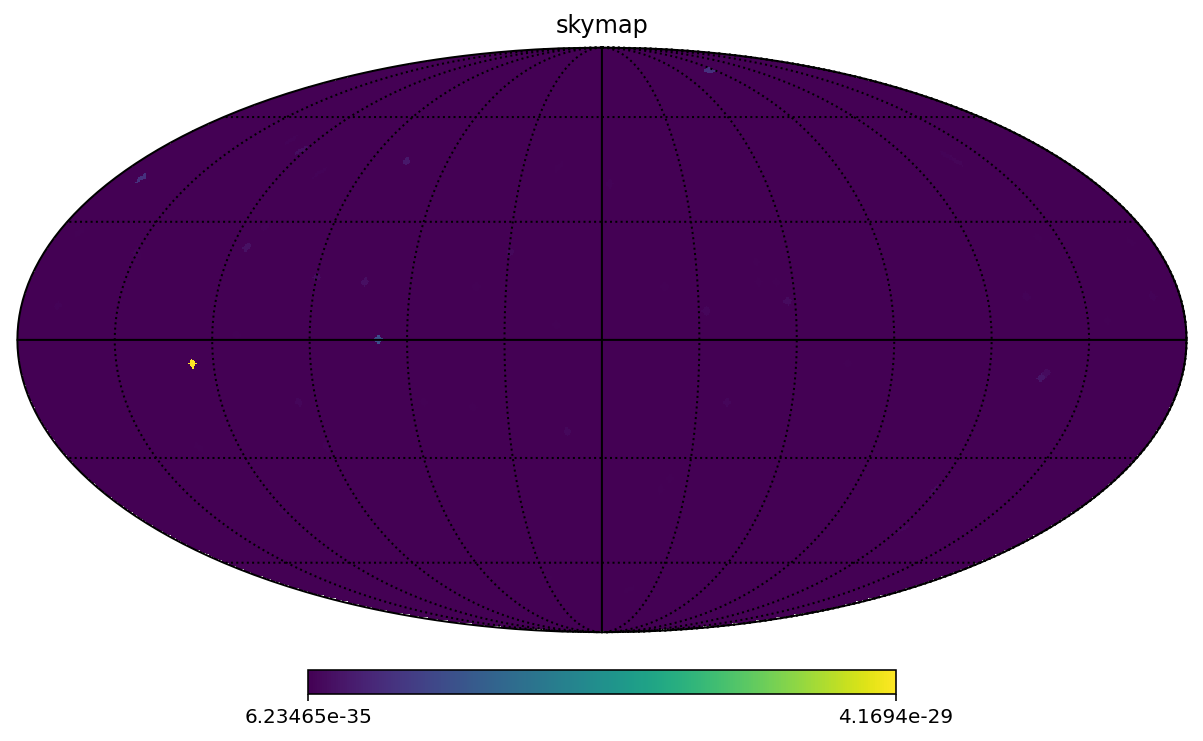

In [14]:

hp.mollview(map_test, title="skymap")
hp.graticule()

# Getting Sph. Harm. Coefs for Skymap, Reconstruction

In [22]:
coef_lmax8 = anis.clmFromMap(map_test, 1)

In [23]:
print(coef_lmax8)

[ 3.47452571e-32 -2.36886938e-32  5.17512386e-33  1.32648619e-32]


In [24]:
map_from_coef_lmax8 = anis.mapFromClm(coef_lmax8, 8)

In [25]:
print(len(map_from_coef_lmax8))

768


0.0 180.0 -180.0 180.0


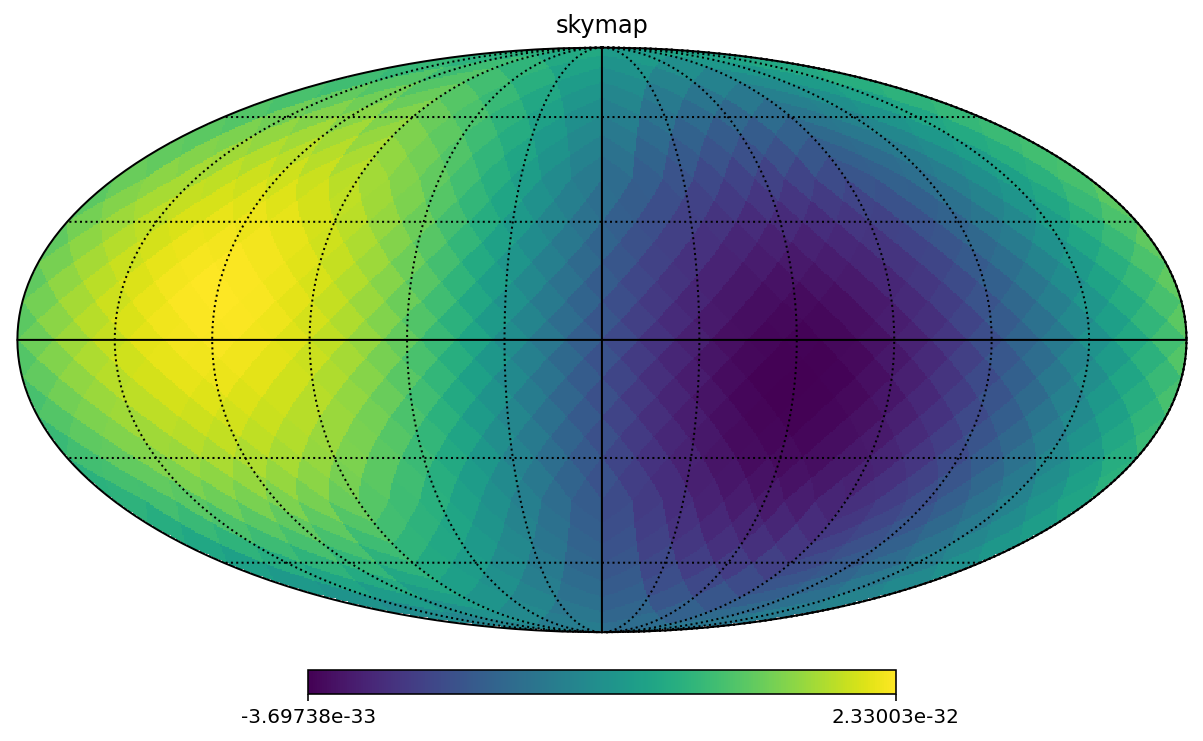

In [26]:
hp.mollview(map_from_coef_lmax8, title="skymap")
hp.graticule()

In [15]:
c_l_lmax8 = hp.anafast(map_test, lmax=8)
e_l_lmax8 = np.arange(len(c_l_lmax8))

# Angular Power Spectra over all Frequencies

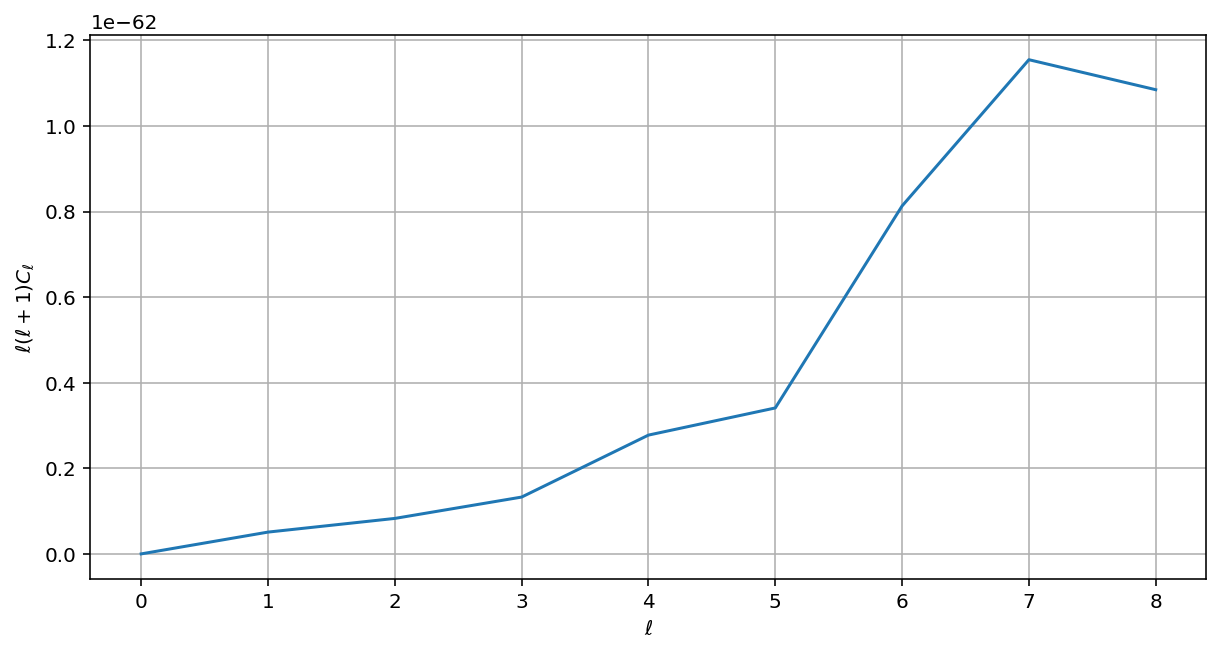

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(e_l_lmax8, e_l_lmax8 * (e_l_lmax8 + 1) * c_l_lmax8)
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.grid()
hp.write_cl("cl.fits", c_l_lmax8, overwrite=True)

In [17]:
print(skymaps.shape)

(360, 12288)


# Per Frequency Skymaps

In [18]:
map_20freqs = np.zeros((20, 12288))

for i in range(20): 
    map_20freqs[i] = skymaps[i,:]


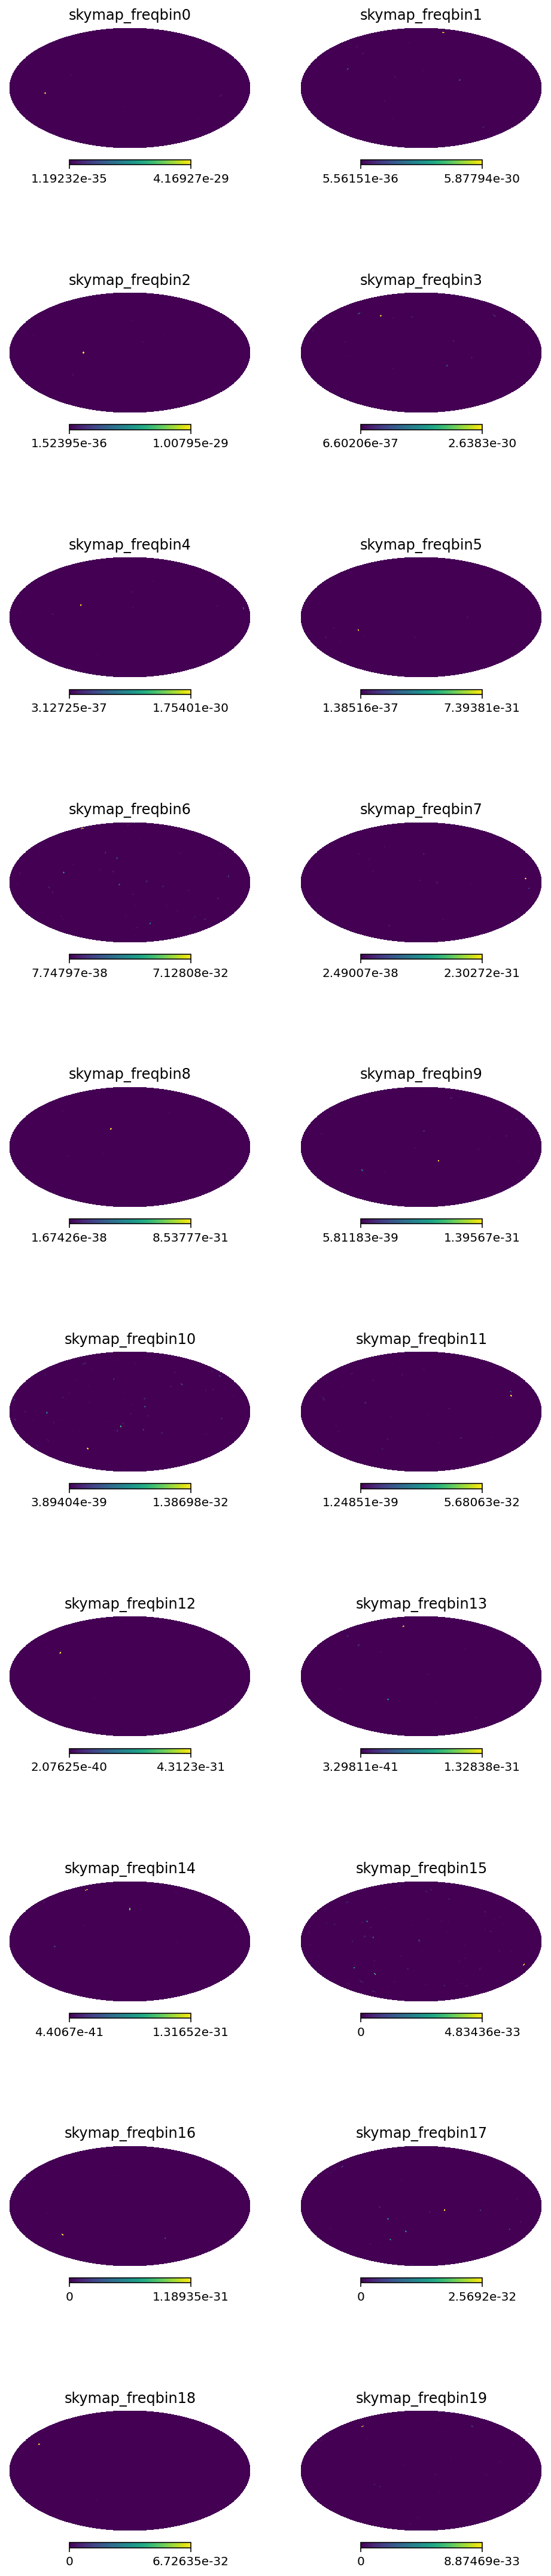

In [19]:


fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7), (ax8, 
      ax9), (ax10, ax11), (ax12, ax13), (ax14, ax15), (ax16, 
      ax17), (ax18, ax19)) = plt.subplots(nrows=10, ncols=2)

ax_list = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, 
      ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, 
      ax17, ax18, ax19]

for i, a in enumerate(ax_list):
    plt.axes(a)
    hp.mollview(map_20freqs[i], title="skymap_freqbin{}".format(i), hold=True)

fig.set_size_inches(8, 40)
# for a in range(2):
#     if a == 0:
#         for b in range(10):
#             plt.axes[b, a] = hp.mollview(map_20freqs[b], title="skymap_freqbin{}".format(b), hold=True)
#     if a == 1:
#         for c in range(10,19):
#             axs[c, a] = hp.mollview(map_20freqs[c], title="skymap_freqbin{}".format(c), hold=True)
#hp.mollview(map_testf0, title="skymap")
#hp.graticule()

In [20]:
last5freqtest = anis.clmFromMap(map_20freqs[-5], lmax=8)

In [21]:
print(last5freqtest)

[ 1.07490703e-35 -3.85328406e-36 -2.40713829e-36  1.59634148e-36
  1.13173936e-36  2.30285343e-36 -6.01052014e-37 -2.57921511e-36
 -2.01107179e-36  3.59145768e-36 -3.63409750e-37 -6.63928920e-37
  2.69525656e-36  1.10409211e-36 -3.62645823e-37  9.39118267e-37
  1.11495745e-37 -2.67088038e-36 -1.29278803e-36  1.61855062e-36
 -2.25278795e-36  1.23636806e-36 -2.10088193e-36 -1.61585413e-36
  4.39498698e-36 -6.89578124e-37 -4.90045907e-36  2.51736327e-36
  6.90519335e-37  1.57095777e-36  2.42274744e-36 -3.26773343e-36
  3.68672614e-36  3.00533202e-37 -1.83500991e-36 -1.08535866e-36
  3.59502251e-36 -3.29236473e-36  2.62971355e-36 -1.43900710e-36
 -1.69929195e-36 -3.06534925e-36  2.36358732e-36 -7.83315556e-37
  8.38403356e-38  5.31232173e-37  2.37106624e-36 -2.03751690e-36
  4.18921128e-37  1.08448253e-36 -8.85582138e-37  1.12388461e-36
  6.28290839e-37 -2.75392036e-36  6.82527099e-37  5.96605766e-37
 -2.44923201e-36  2.51270160e-36 -1.43530404e-36 -1.34784077e-36
 -2.57150478e-36  2.35835

0.0 180.0 -180.0 180.0


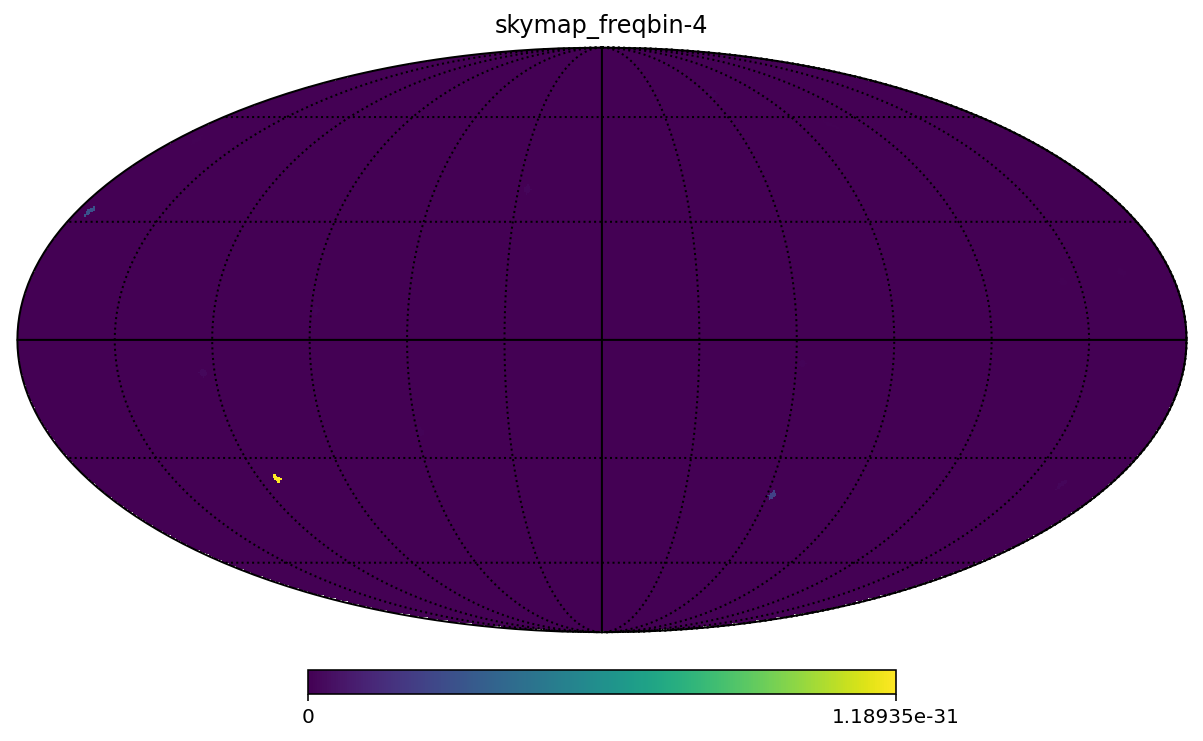

In [22]:
b=-4
hp.mollview(map_20freqs[b], title="skymap_freqbin{}".format(b))
hp.graticule()
fig.set_size_inches(6, 10)


In [23]:
c_l_lmax8_20freqs = np.zeros((20, 9))
e_l_lmax8_20freqs = np.zeros((20, 9))


for i in range(20): 
    c_l_lmax8_20freqs[i] = hp.anafast(map_20freqs[i], lmax=8)
    e_l_lmax8_20freqs[i] = np.arange(len(c_l_lmax8_20freqs[i]))

In [24]:
print(c_l_lmax8_20freqs[-6:])

[[8.42938274e-69 3.71447870e-69 1.47102525e-69 1.40631967e-69
  2.06684886e-69 2.86630955e-69 3.29531109e-69 2.42945806e-69
  1.64642791e-69]
 [1.15541289e-70 7.72800554e-72 3.52712627e-72 3.28080103e-72
  4.92902302e-72 6.23064762e-72 4.72890663e-72 2.91899865e-72
  3.17539148e-72]
 [3.33848453e-69 1.16583891e-69 8.35844484e-70 1.46353064e-69
  1.53261436e-69 1.16929224e-69 1.08415446e-69 1.39428465e-69
  1.40424728e-69]
 [1.07125065e-69 1.63857502e-70 1.03553119e-70 1.70938668e-70
  1.11029708e-70 1.28106759e-70 7.84469305e-71 7.71656039e-71
  1.06359384e-70]
 [6.49612113e-70 3.54936532e-70 3.70242826e-70 3.71696113e-70
  3.80351095e-70 3.67759102e-70 3.70526098e-70 3.88843257e-70
  3.62864339e-70]
 [5.36073192e-71 9.69291358e-72 7.25963185e-72 7.26173761e-72
  7.00338746e-72 5.55465710e-72 5.59077837e-72 8.02069389e-72
  6.92753479e-72]]


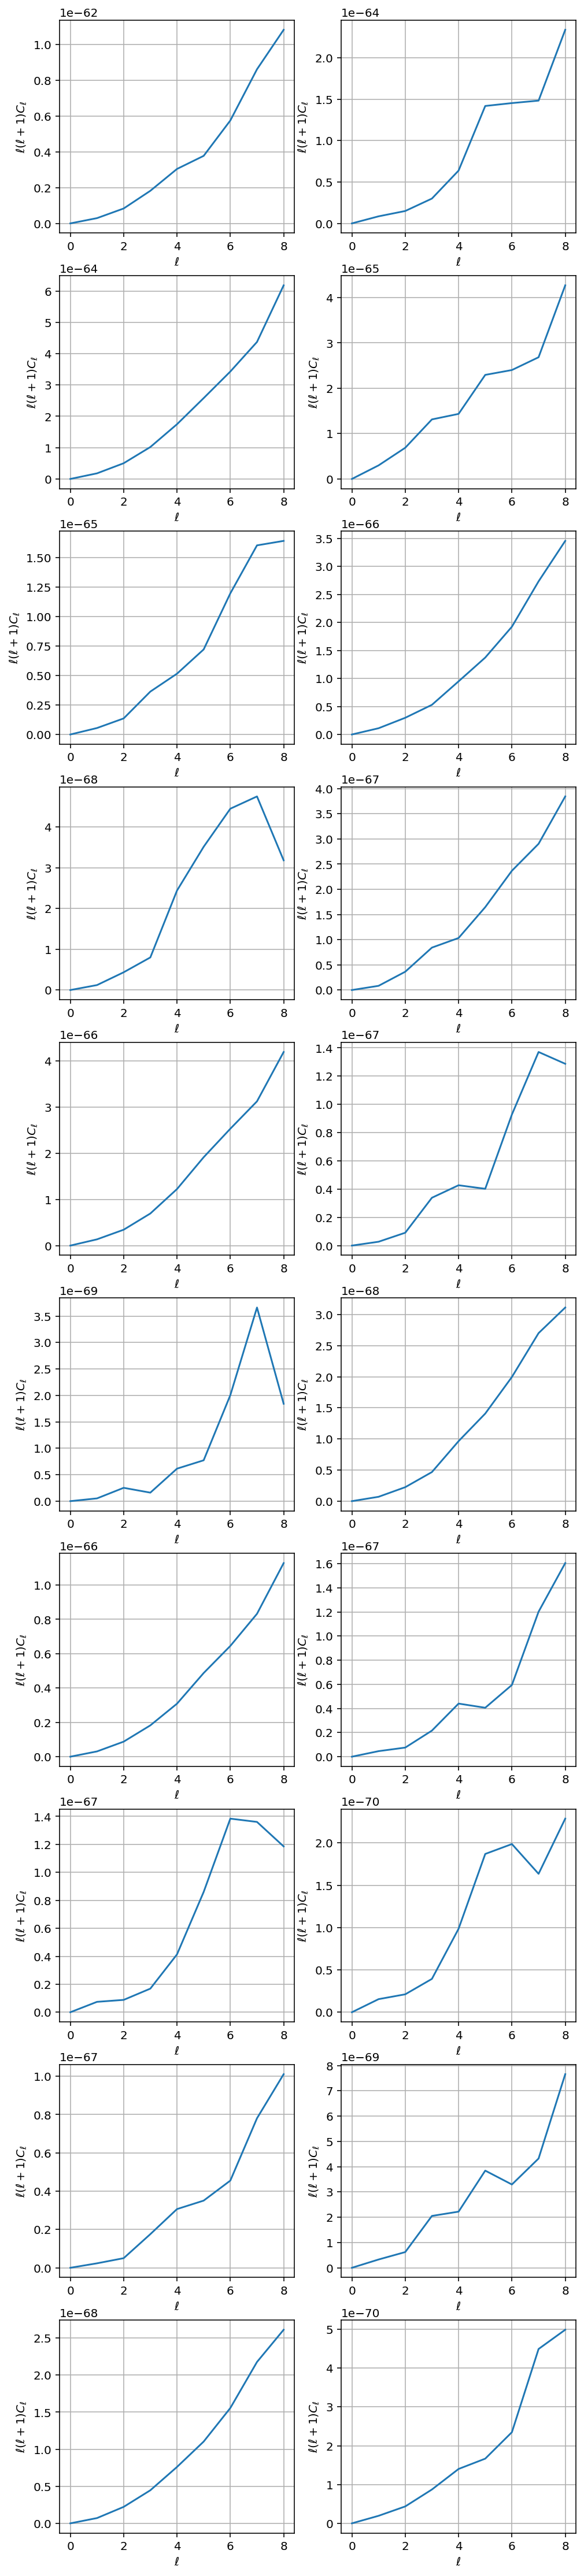

In [25]:
figps, ((axps0, axps1), (axps2, axps3), (axps4, axps5), (axps6, axps7), (axps8, 
      axps9), (axps10, axps11), (axps12, axps13), (axps14, axps15), (axps16, 
      axps17), (axps18, axps19)) = plt.subplots(nrows=10, ncols=2)

axps_list = [axps0, axps1, axps2, axps3, axps4, axps5, axps6, axps7, axps8, 
      axps9, axps10, axps11, axps12, axps13, axps14, axps15, axps16, 
      axps17, axps18, axps19]

for i, a in enumerate(axps_list):
    plt.axes(a)
    plt.plot(e_l_lmax8_20freqs[i], e_l_lmax8_20freqs[i] * 
             (e_l_lmax8_20freqs[i] + 1) * c_l_lmax8_20freqs[i])
    plt.xlabel("$\ell$")
    plt.ylabel("$\ell(\ell+1)C_{\ell}$")
    plt.grid()
figps.set_size_inches(8, 40)

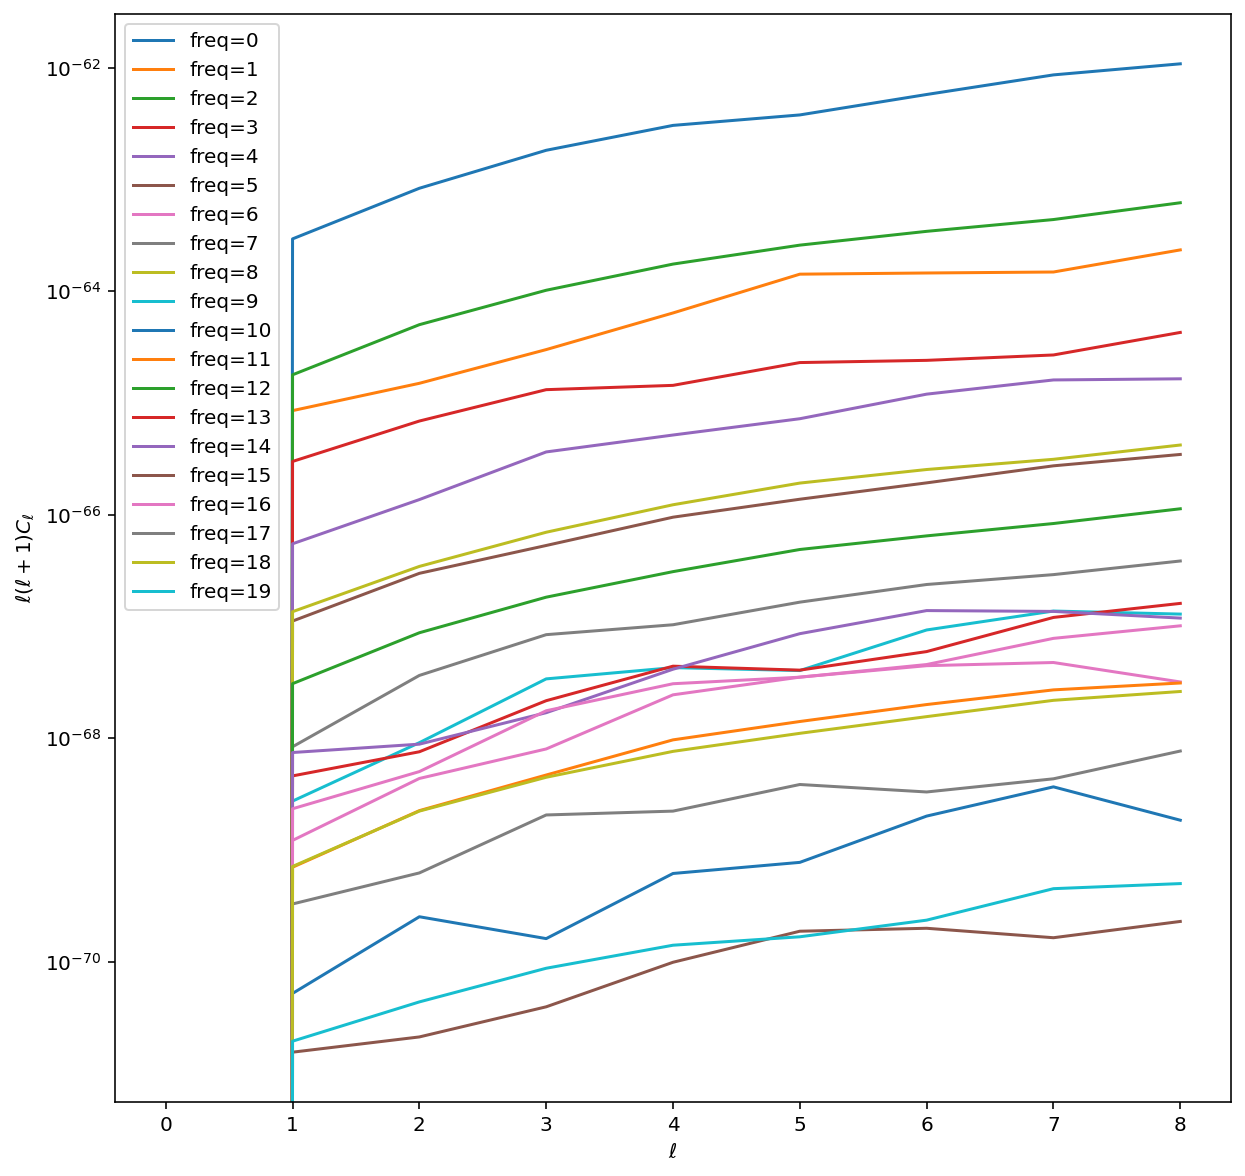

In [26]:
# figps, ((axps0, axps1), (axps2, axps3), (axps4, axps5), (axps6, axps7), (axps8, 
#       axps9), (axps10, axps11), (axps12, axps13), (axps14, axps15), (axps16, 
#       axps17), (axps18, axps19)) = plt.subplots(nrows=10, ncols=2)

# axps_list = [axps0, axps1, axps2, axps3, axps4, axps5, axps6, axps7, axps8, 
#       axps9, axps10, axps11, axps12, axps13, axps14, axps15, axps16, 
#       axps17, axps18, axps19]

figps1 = plt.figure()
axps01 = figps1.add_subplot(111)

for i in range(20):
    plt.plot(e_l_lmax8_20freqs[i], e_l_lmax8_20freqs[i] * 
             (e_l_lmax8_20freqs[i] + 1) * c_l_lmax8_20freqs[i], label='freq='+str(i))
    plt.xlabel("$\ell$")
    plt.ylabel("$\ell(\ell+1)C_{\ell}$")
    plt.yscale('log')
    
    plt.legend()
    plt.grid()
figps1.set_size_inches(10, 10)

# Normalizing Angular Power Spectra

In [27]:
print(np.sum(skymaps[0,:], axis=0))

6.550816235099668e-29


In [28]:
# normalizing each frequency skymap by total strain of each frequency in attempt to normalize the sph harm coefs.
# Getting total h^2 for each freq
h2_tot_20freqs = np.zeros((20, 1))

for i in range(20): 
    h2_tot_20freqs[i] = np.sum(skymaps[i,:], axis=0)


In [29]:
print(map_20freqs[0]/h2_tot_20freqs[0])

[1.88675142e-06 5.03879955e-07 1.81120997e-06 ... 3.59837153e-06
 1.37158038e-06 1.80118571e-06]


In [30]:
# Normalizing
map_20freqs_norm = np.zeros((20, 12288))

for i in range(20):
    map_20freqs_norm[i] = map_20freqs[i]/h2_tot_20freqs[i]


In [31]:
#new coef calc

c_l_lmax8_20freqs_norm = np.zeros((20, 9))
e_l_lmax8_20freqs_norm = np.zeros((20, 9))


for i in range(20): 
    c_l_lmax8_20freqs_norm[i] = hp.anafast(map_20freqs_norm[i], lmax=8)
    e_l_lmax8_20freqs_norm[i] = np.arange(len(c_l_lmax8_20freqs_norm[i]))

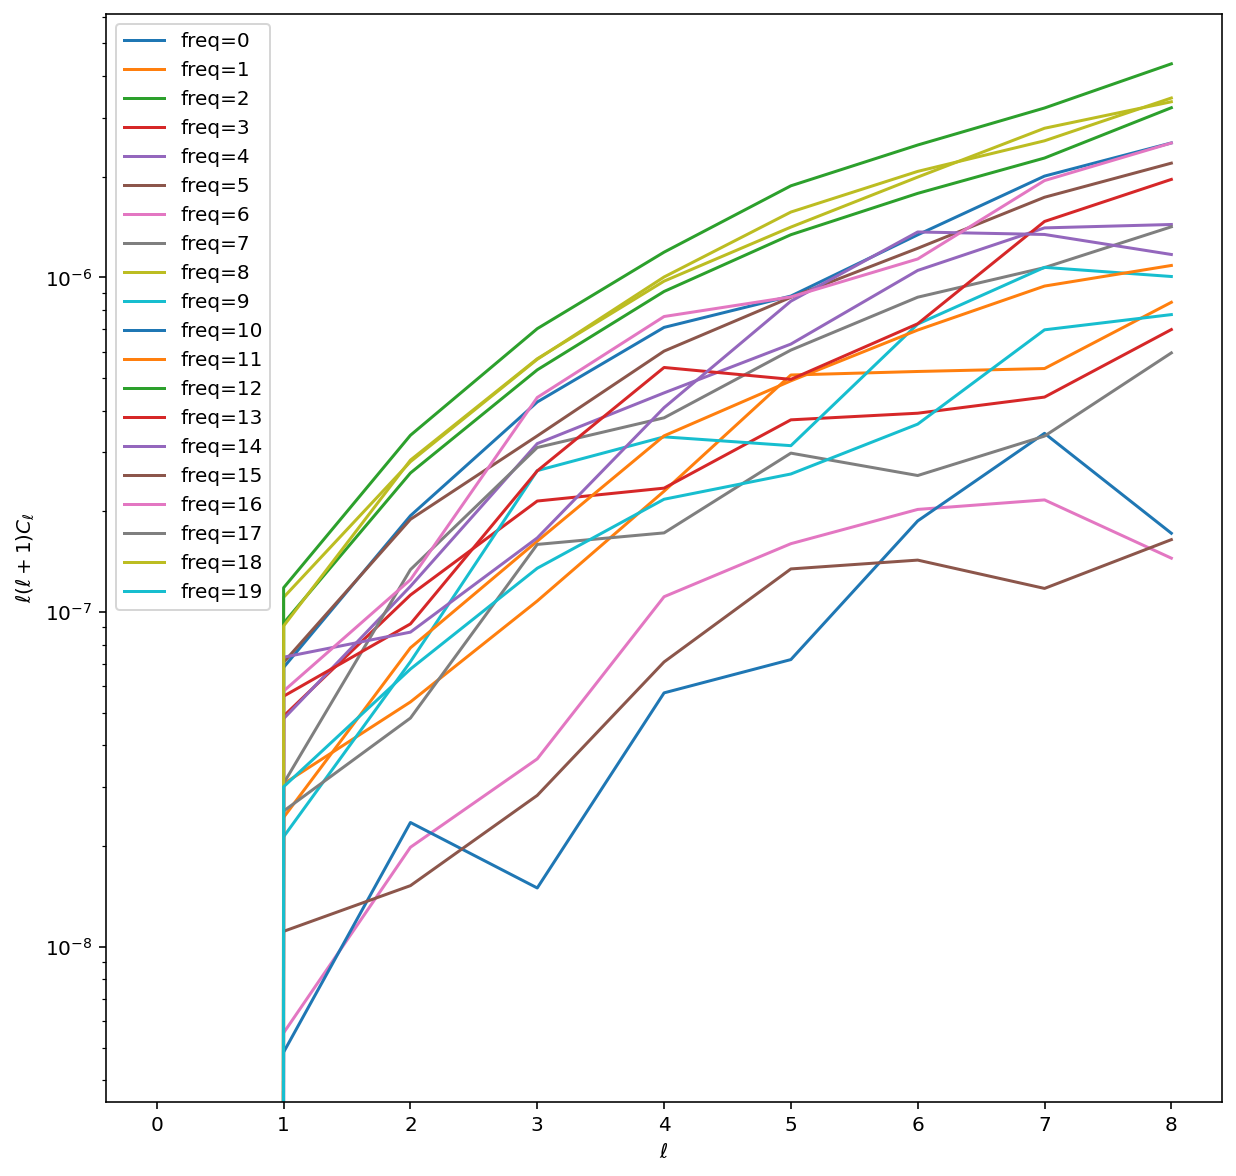

In [32]:
figps1 = plt.figure()
axps01 = figps1.add_subplot(111)

for i in range(20):
    plt.plot(e_l_lmax8_20freqs_norm[i], e_l_lmax8_20freqs_norm[i] * 
             (e_l_lmax8_20freqs_norm[i] + 1) * c_l_lmax8_20freqs_norm[i], label='freq='+str(i))
    plt.xlabel("$\ell$")
    plt.ylabel("$\ell(\ell+1)C_{\ell}$")
    plt.yscale('log')
    
    plt.legend()
    plt.grid()
figps1.set_size_inches(10, 10)


Plot Just Cl

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

for ff in range(F):
    if ff in (0, 10, 20, 30, 39):
        label= ('$f$ = %.2f nHz' % fobs_nHz[ff])
    else: label = None
    ax.plot(l_vals[1:], Cl_lmax8[ff,1:], c=colors[ff], alpha=0.5, label=label,
            marker='o')
ax.set_xlabel('$l$')
ax.set_ylabel('$C_l/C_0$')
ax.set_yscale('log')
ax.set_title('Normalized Spherical Harmonic Coefficients')
ax.legend()
# fig.suptitle('%d Loudest Single Sources' % L, y=.895)
fig.tight_layout()
# fig.savefig(saveloc+'all_freqs.png', dpi=1000)

# fig

# Characteristic Strain Plot

making char strain plot: $h_c = (\Sigma h_i^2 \frac{f}{\Delta f})$

In [33]:
print(np.diff(F_bins).shape)


(360,)


In [38]:
char_strain = np.zeros((360))
straintot = np.sum(skymaps[:,:])
print(straintot)

f_bins_plot = F_bins[:-1]
f_bins_size = np.diff(F_bins)
for i in range(360):
    char_strain[i] = (np.sum(skymaps[i,:]) * (f_bins_plot[i]/f_bins_size[i]))**(1/2)

    

print(f_bins_plot.shape)

1.204402920100633e-28
(360,)


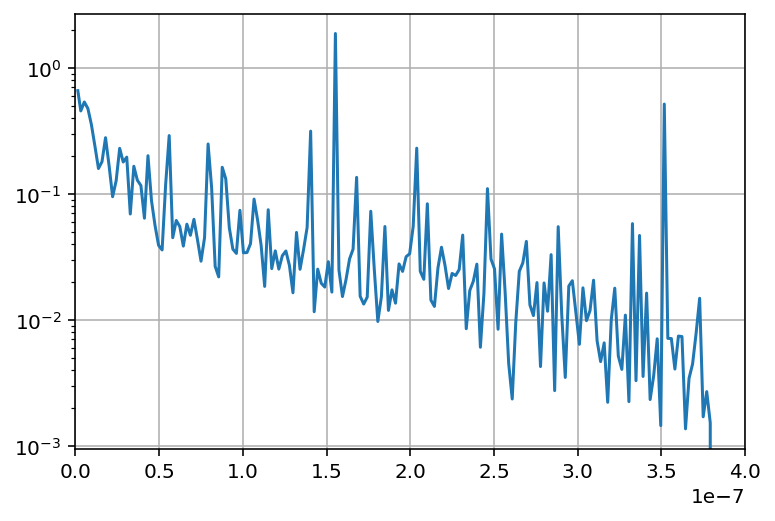

In [39]:
figcs = plt.figure()
axcs = figcs.add_subplot(111)

plt.plot(f_bins_plot, char_strain)
# plt.xlabel("$\ell$")
# plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.xlim((0,4e-7))
plt.yscale('log')

#plt.legend()
plt.grid()

figps1.set_size_inches(10, 10)

In [36]:
print(F_bins.shape)

(361,)
